Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>


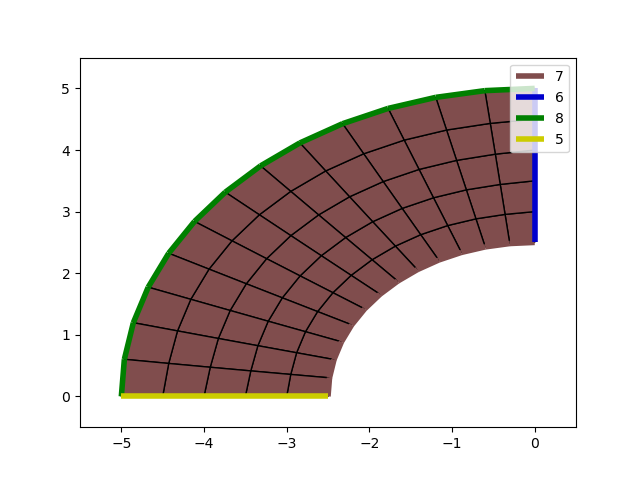

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import scipy.sparse as sparse
import scipy.linalg as linalg
import numpy as np
import collections

import amfe
from amfe.utils.utils import OrderedSet
from amfe.cyclic.cyclic import SelectionOperator, apply_cyclic_symmetry, get_all_dofs, rotate_u, set_cyclic_modes_to_component, create_voigt_rotation_matrix
from amfe.linalg.arnoldi import arnoldi_iteration, inverse_arnoldi_iteration, general_inverse_arnoldi_iteration, generalized_arnoldi_iteration
from amfe.linalg.arnoldi import lanczos, is_eigvec, nullspace, LinearSys, power_iteration, ProjLinearSys, compute_modes

msh_file = r'meshes\one_forth_disk_quad.msh'


m = amfe.Mesh()
m.import_msh(msh_file)

amfe.plotmesh(m)

In [2]:
dirsub = m.get_submesh('phys_group', 7)

cyclic_low = m.get_submesh('phys_group', 5)
cyclic_high = m.get_submesh('phys_group', 6)
domain = m.set_domain('phys_group',9)
domain.split_in_partitions('phys_group')

from ipywidgets import interact
n = len(cyclic_high.global_node_list)-1
@interact(node_id_low=(0,n,1),node_id_high=(0,n,1)) 
def plot_nodes(node_id_low=0,node_id_high=0):
    fig, ax1 = plt.subplots(figsize=(5,5))
    amfe.plot_domain(domain,ax=ax1)
    amfe.plot_submesh(dirsub,ax=ax1,plot_1d=True)
    amfe.plot_submesh(cyclic_low,ax=ax1,plot_1d=True)
    ax1.plot(cyclic_low.get_node_coord(cyclic_low.global_node_list[node_id_low])[0],cyclic_low.get_node_coord(cyclic_low.global_node_list[node_id_low])[1],'o')
    ax1.plot(cyclic_high.get_node_coord(cyclic_high.global_node_list[node_id_high])[0],cyclic_high.get_node_coord(cyclic_high.global_node_list[node_id_high])[1],'o')

interactive(children=(IntSlider(value=0, description='node_id_low', max=5), IntSlider(value=0, description='no…

In [7]:
# creating a mechanical component
my_comp = amfe.MechanicalSystem()
my_comp.set_mesh_obj(m)
my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain(9,my_material)
id_matrix = my_comp.assembly_class.id_matrix

# get dofs
all_dofs = get_all_dofs(id_matrix)
dir_dofs = amfe.get_dofs(dirsub, direction ='xy', id_matrix=id_matrix)

# defining sector angle
# set node diamenter
node_diam = 2
theta = np.pi/2.0 #

# creating node pairs
contact = amfe.Cyclic_Contact(cyclic_low,cyclic_high,sector_angle=theta,unit='rad',tol_radius = 1e-3)


# modifying order of nodes to have the correct node pairs for cyclic symmetry
cyclic_low.global_node_list = contact.slaves_nodes
cyclic_high.global_node_list = contact.master_nodes


superset = OrderedSet(dir_dofs)
low_dofs = OrderedSet(amfe.get_dofs(cyclic_low, direction ='xy', id_matrix=id_matrix)) - superset
high_dofs = OrderedSet(amfe.get_dofs(cyclic_high, direction ='xy', id_matrix=id_matrix)) - superset

boundary_dofs = superset | low_dofs | high_dofs
interior_dofs = list(OrderedSet(all_dofs) - boundary_dofs)
low_dofs = list(low_dofs)
high_dofs = list(high_dofs)

dof_dict = collections.OrderedDict()
dof_dict['d'] = dir_dofs 
dof_dict['l'] = low_dofs 
dof_dict['r'] = high_dofs
dof_dict['i'] = interior_dofs

s = SelectionOperator(dof_dict,id_matrix)

K, f = my_comp.assembly_class.assemble_k_and_f()
M = my_comp.assembly_class.assemble_m()
#plt.matshow(K.todense())

M_block = s.create_block_matrix(M)
M_sector = s.assemble_matrix(M,['r','l','i'])

K_block = s.create_block_matrix(K)
K_sector = s.assemble_matrix(K,['r','l','i'])






Preallocating the stiffness matrix
Done preallocating stiffness matrix with 130 elements and 168 dofs.
Time taken for preallocation: 0.00 seconds.
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils
WARNING! This function will be deprecate. Please import this function from utils


In [8]:
theta

1.5707963267948966

In [9]:
%%time
# building cyclic matrices
beta = node_diam*theta
ej_beta_plus = np.exp(1J*beta)
M_beta = apply_cyclic_symmetry(M_block,'l','r','i',beta,theta=theta,dimension=2) 
K_beta = apply_cyclic_symmetry(K_block,'l','r','i',beta,theta=theta,dimension=2) 

n_modes = 10
eigval, V = compute_modes(K_beta,M_beta,num_of_modes=n_modes)
#eigval, V = sparse.linalg.eigsh(K_beta, k=n_modes, M=M_beta,which='SM')

Wall time: 22.1 ms


In [10]:
eigval

array([2457.15691811-2.11904428e-13j, 2457.3045824 +1.88371037e-13j,
       3580.9409575 +9.24400207e-13j, 3581.66647955-1.83959053e-13j,
       4580.98298437-3.21819707e-13j, 4582.68355538+1.30474356e-13j,
       6978.97867988-0.00000000e+00j, 6979.27847714-9.02589008e-13j,
       7156.98782001-1.40552682e-12j, 7161.46255128-4.07255792e-13j])

<IPython.core.display.Javascript object>


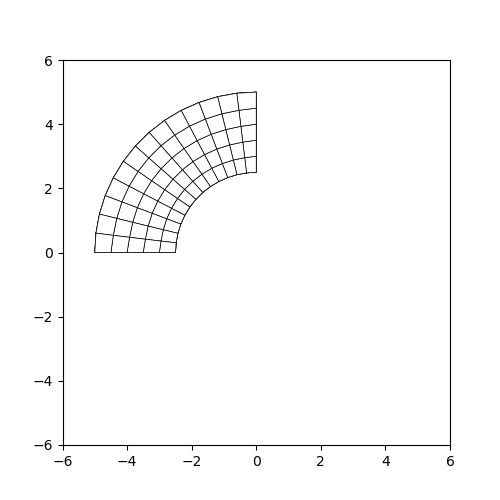

interactive(children=(FloatSlider(value=1.0, description='factor', max=1.0, min=-1.0), IntSlider(value=1, desc…

In [7]:
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import mpl_toolkits.mplot3d as a3
from ipywidgets import interact

my_comp_list = []
angle_list = [0,90,180,270]
if node_diam==1:
    real_or_imag_list=[0,1,0,1]
    sign_list=[1,-1,-1,1]
elif node_diam==2:
    real_or_imag_list=[0,0,0,0]
    sign_list=[1,-1,1,-1]
    #angle_list = [0]

for k,angle in enumerate(angle_list):
    my_comp1 = set_cyclic_modes_to_component(my_comp,s,sign_list[k]*V,beta=beta,compute_left=True,imag=real_or_imag_list[k],dimension=2,rotation=np.deg2rad(angle),theta=theta,unit='rad')
    my_comp_list.append(my_comp1)


fig4,ax3 = plt.subplots(1,figsize=(5,5))
bc = np.array([-6,6])

max_comp=4
@interact(factor=(-1.0,1.0,0.1),mode_id=(0,n_modes,1))
def plot1(factor=1.0,mode_id=1):
    ax3.clear()
    for i,my_comp_i in enumerate(my_comp_list[:max_comp]):
        amfe.plot_system_solution(my_comp_i, factor=1000*factor, ax = ax3, u_id = mode_id)
    ax3.set_xlim(bc)
    ax3.set_ylim(bc)


#ax3.set_axis_off()

#factor_list = 0.2*np.sin(np.linspace(0,2*np.pi,20))
#ani = FuncAnimation(fig4,  plot1,factor_list , init_func=init,interval=10, blit=True)


In [ ]:
my_comp_list